##### Plot posterior pdf, lik function and prior for a given hyperparameter value

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys
np.random.seed(88)
#os.system('rm *.pdf *.eps *.png');

In [2]:
K = 2 # number of kernels
Nphi = 2 # dimension of parameter space
aCoeff  = np.ones((1,K)) 
muVec  = np.zeros((Nphi,K))
SigMat = np.zeros((Nphi,Nphi,K))
rCoeff = 1e-03*np.ones((1,Nphi)) 
sCoeff = 1e-03*np.ones((1,Nphi))

In [3]:
muVec[0,0] = 1.0
muVec[1,1] = 1.0
rho = -0.9
var = 0.05
fac = 0.25
SigMat[:,:,0] = [[var,var*rho],[var*rho,var]]
SigMat[:,:,1] = [[fac*var,fac*var*rho],[fac*var*rho,fac*var]]

In [4]:
def NSBL(logalpIN):
    alp = np.exp(logalpIN)
    A = np.diag(alp)
    Ainv = np.diag(1/alp)
    Bmat = np.zeros((Nphi,Nphi,K))
    Pmat = np.zeros((Nphi,Nphi,K))
    mVec = np.zeros((Nphi,K))
    wVec = np.zeros((1,K))
    vVec = np.zeros((Nphi,K))
    vbarVec = np.zeros((Nphi,1))
    jVec = np.zeros((Nphi,1))
    Hmat = np.zeros((Nphi,Nphi))
    for k in range(0,K):
        Bmat[:,:,k] = SigMat[:,:,k] + Ainv
        Pmat[:,:,k] = Ainv - Ainv@la.inv(Bmat[:,:,k])@Ainv
        mVec[:,k]   = Pmat[:,:,k]@la.inv(SigMat[:,:,k])@muVec[:,k]
        wVec[0,k]   = aCoeff[0,k]*st.multivariate_normal.pdf(muVec[:,k],[0]*Nphi,Bmat[:,:,k])
        for ii in range(0,Nphi):
            vVec[ii,k] = 0.5*(1.0 - alp[ii]*(Pmat[ii,ii,k] + mVec[ii,k]**2))
    evid = np.sum(wVec)
    wVec = wVec/evid
    objFun = np.log(evid) + np.dot(rCoeff[0,:],logalpIN) - np.dot(sCoeff[0,:],alp)
    for ii in range(0,Nphi):
        vbarVec[ii,0] = np.dot(wVec[0,:],vVec[ii,:])
        jVec[ii,0]   = vbarVec[ii,0] + rCoeff[0,ii] - sCoeff[0,ii]*alp[ii]
        for jj in range(0,ii):
            Hmat[ii,jj] = Hmat[jj,ii]
        for jj in range(ii,Nphi):
            tmpij = 1.0 if ii==jj else 0.0
            for k in range(0,K):
                Hmat[ii,jj] = Hmat[ii,jj] + wVec[0,k]*(alp[ii]*alp[jj]*(0.5*Pmat[ii,jj,k]**2 \
                                    + mVec[ii,k]*mVec[jj,k]*Pmat[ii,jj,k]) \
                                    + vVec[jj,k]*(vVec[ii,k] - vbarVec[ii,0]))
            Hmat[ii,jj] = Hmat[ii,jj] + tmpij*(vbarVec[ii,0] - sCoeff[0,ii]*alp[ii] - 0.5)
    return np.log(evid), objFun, jVec[:,0], Hmat

In [5]:
Ngrd  = 100
LogEvidgrd  = np.zeros((Ngrd,Ngrd))
ObjFungrd   = np.zeros((Ngrd,Ngrd))
JacVecgrd   = np.zeros((Ngrd,Ngrd,Nphi))
LogAlp1bnd = [-5,10]
LogAlp2bnd = [-5,10]
LogAlp1rng = np.linspace(LogAlp1bnd[0],LogAlp1bnd[1],Ngrd)
LogAlp2rng  = np.linspace(LogAlp2bnd[0],LogAlp2bnd[1],Ngrd)
LogAlp1grd,LogAlp2grd = np.meshgrid(LogAlp1rng,LogAlp2rng)
for i in range(0,Ngrd):
    for j in range(0, Ngrd):
        LogAlpCur = np.array([LogAlp1grd[i,j],LogAlp2grd[i,j]])
        LogEvidgrd[i,j], ObjFungrd[i,j], JacVecgrd[i,j,:], _ = NSBL(LogAlpCur)

In [6]:
def myFun(xin):
    _, Otmp, Jtmp, _ = NSBL(xin)
    return -Otmp, -Jtmp
def myFunb(xin):
    _, Otmp, _, _ = NSBL(xin)
    return -Otmp
def myFunHess(xin):
    _, _, _, Htmp = NSBL(xin)
    return -Htmp

In [7]:
maxIter = 50
ftol = 1e-04
jtol = 1e-04
LogAlp0 = np.array([-5,-5])
#res = sopt.minimize(myFunb, LogAlp0, method='Nelder-Mead',options={'maxfev':maxIter,'return_all': True})
#res = sopt.minimize(myFun, LogAlp0, method='Newton-CG',jac=True, hess=myFunHess, options={'maxiter':maxIter,'return_all': True,'xtol':ftol})
res = sopt.minimize(myFun, LogAlp0, method='trust-ncg',jac=True, hess=myFunHess, options={'maxiter':maxIter,'return_all': True,'gtol':jtol})
#res = sopt.minimize(myFun, LogAlp0, method='trust-exact',jac=True, hess=myFunHess, options={'maxiter':maxIter,'return_all': True,'gtol':jtol})
print(res)
LogAlpIter = np.zeros((res.nit,Nphi))
fevalIter = np.zeros((res.nit,2))
for i in range(0,res.nit):
    LogAlpIter[i,:] = res.allvecs[i]
    fevalIter[i,0], fevalIter[i,1], _, _ = NSBL(LogAlpIter[i,:])
#print(LogAlpIter)

 allvecs: [array([-5., -5.]), array([-4.29289232, -4.29289412]), array([-2.87867133, -2.87868799]), array([-0.0499905 , -0.05051459]), array([1.14805338, 1.06212375]), array([0.93366417, 0.62799874]), array([0.93366417, 0.62799874]), array([ 2.18806731, -0.92971521]), array([3.66212571, 0.42200659]), array([5.62238786, 0.02530481]), array([ 5.17363900e+00, -3.11328544e-03]), array([5.10406431, 0.00575521]), array([5.10288783, 0.00572578])]
     fun: 0.5053210487132895
    hess: array([[0.27436901, 0.00113323],
       [0.00113323, 0.49532479]])
     jac: array([8.78793832e-08, 2.90230912e-11])
 message: 'Optimization terminated successfully.'
    nfev: 13
    nhev: 11
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([5.10288783, 0.00572578])


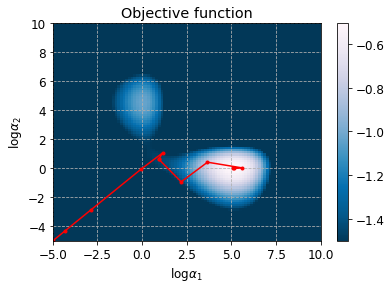

In [8]:
mpl.rcParams.update({'font.size':12})
minVal = -1.5
plt.figure(1)
plt.plot(LogAlpIter[:,0],LogAlpIter[:,1],'r.')
plt.plot(LogAlpIter[:,0],LogAlpIter[:,1],'r-')
plt.pcolor(LogAlp1grd,LogAlp2grd,ObjFungrd,cmap='PuBu_r',vmin=minVal)
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title('Objective function')
plt.savefig('plot_iter.eps',bbox_inches='tight')

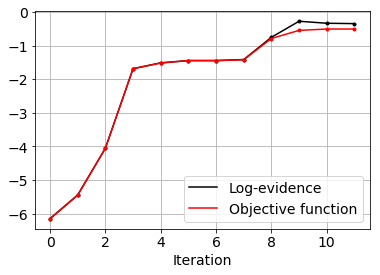

In [9]:
mpl.rcParams.update({'font.size':14})
plt.figure(1)
plt.plot(fevalIter[:,0],'k.')
plt.plot(fevalIter[:,0],'k-',label='Log-evidence')
plt.plot(fevalIter[:,1],'r.')
plt.plot(fevalIter[:,1],'r-',label='Objective function')
#plt.legend(loc='best', numpoints = 1)
plt.legend(loc='lower right', numpoints = 1)
plt.grid(True)
plt.xlabel('Iteration')
plt.savefig('plot_feval.eps',bbox_inches='tight')